# Решение задачи "Кредитный скоринг"

Задача состоит в том, чтобы по различным характеристикам клиентов спрогнозировать целевую переменную - имел клиент просрочку 90 и более дней или нет (и если имел, то банк не будет выдавать кредит этому клиенту, а иначе будет).

## <font color='green'>1. Загрузка данных и их первичный анализ</font>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-02-26 21:40:46--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-02-26 21:40:47 (910 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [3]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \
!pip3 install psycopg2-binary

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:7 http://archive.ubuntu.com/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu 

In [4]:
import psycopg2

conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

In [5]:
import pandas as pd

query = "SELECT * from public.credit_scoring"
data = pd.read_sql_query(query, conn)


# **Логистическая регрессия**

Описание данных скоринг:

* **SeriousDlqin2yrs**: Клиент имел просрочку 90 и более дней


* **RevolvingUtilizationOfUnsecuredLines**: Общий баланс средств (общий баланс по кредитным картам и личным кредитным линиям, за исключением недвижимости и задолженности без рассрочки, такой как автокредиты, деленный на сумму кредитных лимитов).
* **age**: Возраст заемщика
* **NumberOfTime30-59DaysPastDueNotWorse**: Сколько раз за последние 2 года наблюдалась просрочка 30-59 дней.
* **DebtRatio**: Ежемесячные расходы (платеж по долгам, алиментам, расходы на проживания) деленные на месячный доход.
* **MonthlyIncome**: Ежемесячный доход.
* **NumberOfOpenCreditLinesAndLoans**: Количество открытых кредитов (напрмер, автокредит или ипотека) и кредитных карт.
* **NumberOfTimes90DaysLate**: Сколько раз наблюдалась просрочка (90 и более дней).
* **NumberRealEstateLoansOrLines**: Количество кредиов (в том числе под залог жилья)
* **NumberOfTime60-89DaysPastDueNotWorse**: Сколько раз за последние 2 года заемщик задержал платеж на 60-89 дней.
* **NumberOfDependents**: Количество иждивенцев на попечении (супруги, дети и др).





In [6]:
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [7]:
data.shape

(150000, 11)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [9]:
data = data.drop_duplicates()

In [10]:
data.shape

(149391, 11)

In [11]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,149391.000000,149391.000000,149391.000000,149391.000000,149391.000000,1.201700e+05,149391.000000,149391.000000,149391.000000,149391.000000,145563.000000
mean,0.066999,6.071087,52.306237,0.393886,354.436740,6.675098e+03,8.480892,0.238120,1.022391,0.212503,0.759863
std,0.250021,250.263672,14.725962,3.852953,2041.843455,1.438958e+04,5.136515,3.826165,1.130196,3.810523,1.116141
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030132,41.000000,0.000000,0.177441,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154235,52.000000,0.000000,0.368234,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.556494,63.000000,0.000000,0.875279,8.250000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [12]:
age_median = data[data.age.between(21, 74)].age.median()

Кредит могут получить граждани от 21 года, заменим возраст на медианный для тех строк у которых age < 21

In [13]:
data[data.age < 21].head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65695,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


In [14]:
data['age'].mask(data['age'] < 21, age_median, inplace=True)

In [15]:
data[data.age < 21].head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents


Так же кредит как правило выдают до определенного возраста (в зависимости от политики банка) в нашем примере установим это ограничение до 75 лет

In [16]:
data = data[data.age < 75]

Глядя на данные можно заметить, что есть большие выбросы по полям MonthlyIncome, DebtRatio и RevolvingUtilizationOfUnsecuredLines. 

+ Для поля RevolvingUtilizationOfUnsecuredLines предположу, что максимальное значение должно быть 1, т.к. мы делим общий баланс по кредитным картам на сумму кредитных лимитов. Следовательно уберем из наших данных все строки где данный показатель выше.
+ Для поля DebtRatio максимальное число может превышать 1, но при таком значение расходы клиента будут превышать его доход. Для нас будет рискованно выдавать кредит для такой категории, следовательно данные клиенты не являются целевыми для нашей модели.
+ Для поля MonthlyIncome максимальное значение может уходить в бесконечность, и здесь мы попробуем проверить две гипотезы. Первая будет заключаться в том что, наши целевые клиенты будут иметь ограниченных уровень дохода, предположим до 20000 у.е., а клиенты с доходом выше не являются целевыми для нашей модели, для них стоит использовать отдельную модель. Во второй мы уберем ограничения и будем считать что клиент с любым доходом нам подходит. Далее посмотрим как при этом измениться точность нашей модели. И оставим лучший вариант.

## **Первая гипотеза**

In [17]:
data_1 = data[(data.MonthlyIncome < 20001) & (data.DebtRatio <= 1) & (data.RevolvingUtilizationOfUnsecuredLines <= 1)]

In [18]:
data_1.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,101062.000000,101062.000000,101062.000000,101062.000000,101062.000000,101062.000000,101062.000000,101062.000000,101062.000000,101062.000000,101062.000000
mean,0.063417,0.324282,49.439473,0.386179,0.317504,6405.277503,8.696107,0.221369,1.034672,0.199482,0.889810
std,0.243712,0.337537,12.621080,3.736185,0.221338,3655.369496,5.089699,3.705901,1.041678,3.692450,1.160577
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.038020,40.000000,0.000000,0.149692,3708.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.180971,50.000000,0.000000,0.290393,5666.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.557848,59.000000,0.000000,0.449751,8345.000000,11.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,1.000000,74.000000,98.000000,1.000000,20000.000000,57.000000,98.000000,20.000000,98.000000,20.000000


Дополнительно проверим, следующее предположение, есть ли закономерности в возрасте у людей которые имеют задолженность более 90 дней и наоборот.

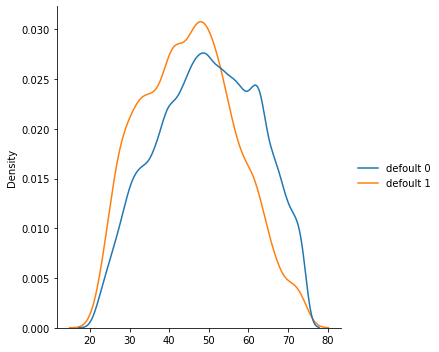

In [19]:
from numpy.lib.type_check import common_type
import seaborn as sns
sns.displot({
    "defoult 0":data_1[data_1.SeriousDlqin2yrs==0].age,
    "defoult 1":data_1[data_1.SeriousDlqin2yrs==1].age,
    }, kind="kde", common_norm=False)

Как видно на графике, такой закономерности нет. Распределения очень похожи.

Проверим аналогичное предположение, но уже с уровнем дохода.

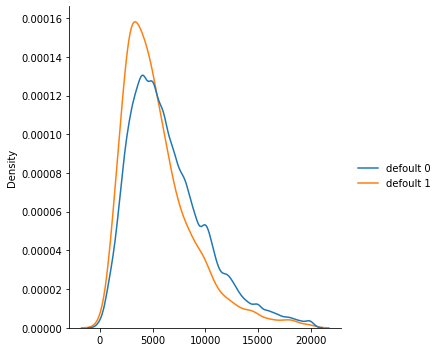

In [20]:
sns.displot({
    "defoult 0":data_1[data_1.SeriousDlqin2yrs==0].MonthlyIncome,
    "defoult 1":data_1[data_1.SeriousDlqin2yrs==1].MonthlyIncome,
    }, kind="kde", common_norm=False)

Как видно на графике, такой закономерности так же нет. Распределения очень похожи. За исключениме того, что клиентов у которых просрочка более 90 дней больше на промежутке с доходом ~4к у.е. 

Добавим несколько фич.
В поле **costs** посчитаем реальную сумму которую тратит заемщик.

In [21]:
data_1["costs"] = data_1['DebtRatio'] * data_1['MonthlyIncome']

Так же добавим фичу care - где отобразим сколько средств уходит на одного члена семьи.

In [22]:
data_1["care"] = data_1['MonthlyIncome'] / (data_1['NumberOfDependents'] + 1)

In [23]:
data_1

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,costs,care
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,7323.197016,3040.000000
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,316.878123,1300.000000
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,258.914887,3042.000000
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,118.963951,3300.000000
5,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0,1314.624392,1750.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149994,0,0.385742,50,0,0.404293,3400.0,7,0,0,0,0.0,1374.595707,3400.000000
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0,472.774869,2100.000000
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0,4001.283436,1861.333333
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0,0.000000,5716.000000


In [24]:
corr = data_1.corr()
corr.style.background_gradient(cmap='coolwarm')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,costs,care
SeriousDlqin2yrs,1.000000,0.242173,-0.088812,0.122026,0.047642,-0.065746,-0.036785,0.113987,-0.027175,0.098583,0.038314,0.005555,-0.069032
RevolvingUtilizationOfUnsecuredLines,0.242173,1.000000,-0.228781,0.112800,0.128378,-0.121614,-0.182320,0.101331,-0.108471,0.089120,0.065813,0.049696,-0.135885
age,-0.088812,-0.228781,1.000000,-0.047056,0.013047,0.195028,0.237755,-0.048553,0.153589,-0.044965,-0.151037,0.105897,0.267216
NumberOfTime30-59DaysPastDueNotWorse,0.122026,0.112800,-0.047056,1.000000,-0.034807,-0.040502,-0.050189,0.980193,-0.031606,0.983782,-0.001297,-0.029392,-0.034211
DebtRatio,0.047642,0.128378,0.013047,-0.034807,1.000000,-0.071309,0.355129,-0.054931,0.527984,-0.050086,0.079815,0.656491,-0.104443
MonthlyIncome,-0.065746,-0.121614,0.195028,-0.040502,-0.071309,1.000000,0.302297,-0.049068,0.418675,-0.043997,0.185289,0.571917,0.667401
NumberOfOpenCreditLinesAndLoans,-0.036785,-0.182320,0.237755,-0.050189,0.355129,0.302297,1.000000,-0.075977,0.415175,-0.066317,0.036243,0.475631,0.222991
NumberOfTimes90DaysLate,0.113987,0.101331,-0.048553,0.980193,-0.054931,-0.049068,-0.075977,1.000000,-0.046096,0.991888,-0.007472,-0.050125,-0.037194
NumberRealEstateLoansOrLines,-0.027175,-0.108471,0.153589,-0.031606,0.527984,0.418675,0.415175,-0.046096,1.000000,-0.039746,0.116324,0.739648,0.257015
NumberOfTime60-89DaysPastDueNotWorse,0.098583,0.089120,-0.044965,0.983782,-0.050086,-0.043997,-0.066317,0.991888,-0.039746,1.000000,-0.008251,-0.043875,-0.033207


Удалим из данных коррелирующие поля, зависимыми будем считать связи от 0,5 до 1 (по модулю).

In [25]:
data_1 = data_1.drop(['DebtRatio','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberRealEstateLoansOrLines', 'NumberOfDependents', 'MonthlyIncome'],axis=1)

In [26]:
corr = data_1.corr()
corr.style.background_gradient(cmap='coolwarm')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,costs,care
SeriousDlqin2yrs,1.000000,0.242173,-0.088812,-0.036785,0.113987,0.005555,-0.069032
RevolvingUtilizationOfUnsecuredLines,0.242173,1.000000,-0.228781,-0.182320,0.101331,0.049696,-0.135885
age,-0.088812,-0.228781,1.000000,0.237755,-0.048553,0.105897,0.267216
NumberOfOpenCreditLinesAndLoans,-0.036785,-0.182320,0.237755,1.000000,-0.075977,0.475631,0.222991
NumberOfTimes90DaysLate,0.113987,0.101331,-0.048553,-0.075977,1.000000,-0.050125,-0.037194
costs,0.005555,0.049696,0.105897,0.475631,-0.050125,1.000000,0.328490
care,-0.069032,-0.135885,0.267216,0.222991,-0.037194,0.328490,1.000000


### **Обучение модели**

Сформируем матрицу X объект-признак и вектор y целевой переменной.

In [27]:
y = data_1['SeriousDlqin2yrs']
X = data_1.drop('SeriousDlqin2yrs', axis=1)

Мы разбиваем данные на train и test, чтобы:

на тренировочных данных обучить модель
на тестовых применить обученную модель и затем проверить качество модели

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

Отмасштабируем признаки при помощи StandardScaler, обучив метод на тренировочных данных и применив его и к трейну, и к тесту.

In [29]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(Xtrain)

Xtrain = pd.DataFrame(ss.transform(Xtrain), columns=X.columns)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=X.columns)

Xtrain.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,costs,care
0,-0.959265,0.283710,-0.135918,-0.059447,-0.508677,-0.104573
1,-0.710215,0.046006,-0.332861,-0.059447,-1.127379,-0.045924
2,-0.952666,-0.667108,1.242680,-0.059447,-1.163529,0.220370
3,-0.599174,-0.112464,-0.726746,-0.059447,-0.067245,-0.374037
4,-0.937036,-1.380222,-1.317574,-0.059447,-0.941886,-0.724341


Обучим логистическую регрессию на train и сделаем предсказание на новых для нее данных (test).

In [30]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression() # объявление модели
model.fit(Xtrain, ytrain) # обучение модели

LogisticRegression()

In [31]:
pred_test = model.predict(Xtest) # предсказание классов

In [32]:
pred_test

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
accuracy_score(ytest, pred_test)  # 0.9342199002612206

0.9342199002612206

Проверим, сбалансирована ли выборка.

In [34]:
y.value_counts()

0    94653
1     6409
Name: SeriousDlqin2yrs, dtype: int64

Баланса классов нет: большинство клиентов не имеют просрочку больше чем на 90 дней

In [35]:
from sklearn.metrics import confusion_matrix

confusion_matrix(ytest, pred_test)

array([[23584,    13],
       [ 1649,    20]])

In [36]:
ytest.value_counts()

0    23597
1     1669
Name: SeriousDlqin2yrs, dtype: int64

In [37]:
from sklearn.metrics import recall_score

recall_score(ytest, pred_test) 

0.011983223487118035

In [38]:
from sklearn.metrics import precision_score

precision_score(ytest, pred_test)

0.6060606060606061

In [39]:
probs = model.predict_proba(Xtest)

probs[:10]

array([[0.93234369, 0.06765631],
       [0.96332775, 0.03667225],
       [0.83822595, 0.16177405],
       [0.83277529, 0.16722471],
       [0.83833921, 0.16166079],
       [0.97541502, 0.02458498],
       [0.91235913, 0.08764087],
       [0.97139632, 0.02860368],
       [0.7872574 , 0.2127426 ],
       [0.98075812, 0.01924188]])

In [40]:
model.coef_, model.intercept_

(array([[ 0.84509522, -0.15229518,  0.17296579,  0.09514255,  0.0563159 ,
         -0.21582549]]), array([-3.11765017]))

In [41]:
coef_table = pd.DataFrame({'features' : list(X.columns), 'weights' : list(model.coef_[0])})

coef_table.sort_values(by='weights')

,features,weights
5,care,-0.215825
1,age,-0.152295
4,costs,0.056316
3,NumberOfTimes90DaysLate,0.095143
2,NumberOfOpenCreditLinesAndLoans,0.172966
0,RevolvingUtilizationOfUnsecuredLines,0.845095


## **Вторая гипотеза**

In [42]:
data_2 = data[(data.DebtRatio <= 1) & (data.RevolvingUtilizationOfUnsecuredLines <= 1)]

In [43]:
data_2.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,103957.000000,103957.000000,103957.000000,103957.000000,103957.000000,1.030530e+05,103957.000000,103957.000000,103957.000000,103957.000000,103730.000000
mean,0.063565,0.324661,49.509643,0.431553,0.313501,7.096332e+03,8.699905,0.268082,1.047597,0.245957,0.894341
std,0.243977,0.338847,12.619799,4.304056,0.222831,1.525078e+04,5.153650,4.279733,1.090566,4.268489,1.165167
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.037307,40.000000,0.000000,0.143898,3.750000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.180183,50.000000,0.000000,0.285808,5.771000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559212,60.000000,0.000000,0.445983,8.583000e+03,11.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,1.000000,74.000000,98.000000,1.000000,3.008750e+06,57.000000,98.000000,29.000000,98.000000,20.000000


In [44]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103957 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      103957 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  103957 non-null  float64
 2   age                                   103957 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  103957 non-null  int64  
 4   DebtRatio                             103957 non-null  float64
 5   MonthlyIncome                         103053 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       103957 non-null  int64  
 7   NumberOfTimes90DaysLate               103957 non-null  int64  
 8   NumberRealEstateLoansOrLines          103957 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  103957 non-null  int64  
 10  NumberOfDependents                    103730 non-null  float64
dtype

 При таких ограничениях у нас появились поля с пустыми данными **MonthlyIncome** и **NumberOfDependents**.
 Данные можно заполнить средним значением или медианой в рамках возраста, НО, доход и кол-во иждевенцев в 21 год может очень сильно отличаться от 40 лет и так делее.
 В таком случае предлагаю добавить фичу которая будет делить наших клиентов на группы по возрасту (например с шагом по 7 лет), и уже в рамках этих групп будем считать среднее/медиану.

In [45]:
data_2["age_grp"] = data_2.age.apply(lambda x: x // 7 - 2)

In [46]:
data_2.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_grp
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,4
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,3
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,3
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,2
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,5


In [47]:
data_2.groupby(data_2.age_grp).agg({'MonthlyIncome': ['median', 'mean'], 'NumberOfDependents': ['median', 'mean']})

MonthlyIncome              NumberOfDependents          
               median         mean             median      mean
age_grp                                                        
1              2400.0  2712.628212                0.0  0.224343
2              4060.0  4835.109145                0.0  0.676348
3              5579.0  6548.667302                1.0  1.270201
4              6300.0  7694.255713                1.0  1.445072
5              6648.0  8191.290070                1.0  1.114268
6              6514.0  7926.265964                0.0  0.634079
7              6000.0  7699.692469                0.0  0.363979
8              5001.0  6235.039693                0.0  0.235028

С учетом выбросов предлагаю взять медиану, для более честного результата.

In [48]:
data_2[data_2.MonthlyIncome.isna()]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_grp
52,0,1.0,62,0,0.0,NaN,1,0,0,0,0.0,6
238,0,1.0,28,0,0.0,NaN,0,0,0,0,NaN,2
331,0,1.0,29,0,0.0,NaN,0,0,0,0,0.0,2
1066,0,1.0,68,1,0.0,NaN,0,1,0,0,0.0,7
1126,0,1.0,70,0,0.0,NaN,1,0,0,0,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...
149390,0,0.0,54,0,0.0,NaN,4,0,0,0,0.0,5
149622,0,1.0,46,0,0.0,NaN,0,1,0,0,0.0,4
149666,0,1.0,59,0,0.0,NaN,2,0,0,0,0.0,6
149853,0,0.0,68,1,0.0,NaN,4,0,0,0,0.0,7


Заполним пустые значения по доходу в рамках группы.

In [49]:
data_2["MonthlyIncome"] = data_2.groupby(data_2.age_grp, sort=False)["MonthlyIncome"].apply(lambda x: x.fillna(x.median()))

In [50]:
data_2[data_2.MonthlyIncome.isna()]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_grp


Заполним пустые значения по иждевенцам в рамках группы.

In [51]:
data_2["NumberOfDependents"] = data_2.groupby(data_2.age_grp, sort=False)["NumberOfDependents"].apply(lambda x: x.fillna(x.median()))

In [52]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103957 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      103957 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  103957 non-null  float64
 2   age                                   103957 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  103957 non-null  int64  
 4   DebtRatio                             103957 non-null  float64
 5   MonthlyIncome                         103957 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       103957 non-null  int64  
 7   NumberOfTimes90DaysLate               103957 non-null  int64  
 8   NumberRealEstateLoansOrLines          103957 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  103957 non-null  int64  
 10  NumberOfDependents                    103957 non-null  float64
 11  

Пустых значений у нас больше нет.

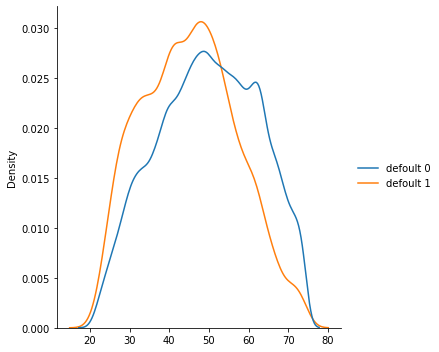

In [53]:
from numpy.lib.type_check import common_type
import seaborn as sns
sns.displot({
    "defoult 0":data_2[data_2.SeriousDlqin2yrs==0].age,
    "defoult 1":data_2[data_2.SeriousDlqin2yrs==1].age,
    }, kind="kde", common_norm=False)

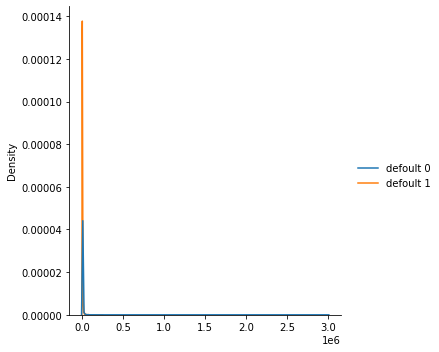

In [54]:
sns.displot({
    "defoult 0":data_2[data_2.SeriousDlqin2yrs==0].MonthlyIncome,
    "defoult 1":data_2[data_2.SeriousDlqin2yrs==1].MonthlyIncome,
    }, kind="kde", common_norm=False)

Здесь мы видим, что уже нарушается нормальное распределение и большая часть данных расположена в левой часть графика.

In [55]:
data_2["costs"] = data_2['DebtRatio'] * data_2['MonthlyIncome']

In [56]:
data_2["care"] = data_2['MonthlyIncome'] / (data_2['NumberOfDependents'] + 1)

In [57]:
corr = data_2.corr()
corr.style.background_gradient(cmap='coolwarm')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_grp,costs,care
SeriousDlqin2yrs,1.000000,0.243618,-0.090778,0.128004,0.044069,-0.018893,-0.038374,0.121308,-0.024133,0.107894,0.035900,-0.089858,0.003530,-0.025496
RevolvingUtilizationOfUnsecuredLines,0.243618,1.000000,-0.227229,0.118723,0.120274,-0.037040,-0.181126,0.109272,-0.101625,0.098536,0.061422,-0.224961,0.042661,-0.052880
age,-0.090778,-0.227229,1.000000,-0.052015,0.010927,0.057793,0.235304,-0.053472,0.148353,-0.050194,-0.149130,0.987807,0.104530,0.106965
NumberOfTime30-59DaysPastDueNotWorse,0.128004,0.118723,-0.052015,1.000000,-0.044827,-0.011277,-0.061028,0.985191,-0.036164,0.987877,-0.008495,-0.050540,-0.035235,-0.011678
DebtRatio,0.044069,0.120274,0.010927,-0.044827,1.000000,-0.054173,0.350761,-0.062238,0.501347,-0.057975,0.078191,0.009800,0.594437,-0.072649
MonthlyIncome,-0.018893,-0.037040,0.057793,-0.011277,-0.054173,1.000000,0.095224,-0.013544,0.136025,-0.012161,0.061359,0.057165,0.208396,0.819270
NumberOfOpenCreditLinesAndLoans,-0.038374,-0.181126,0.235304,-0.061028,0.350761,0.095224,1.000000,-0.083676,0.427624,-0.075195,0.044839,0.232101,0.470298,0.098260
NumberOfTimes90DaysLate,0.121308,0.109272,-0.053472,0.985191,-0.062238,-0.013544,-0.083676,1.000000,-0.049232,0.993951,-0.014142,-0.051877,-0.052292,-0.013134
NumberRealEstateLoansOrLines,-0.024133,-0.101625,0.148353,-0.036164,0.501347,0.136025,0.427624,-0.049232,1.000000,-0.043771,0.120439,0.146436,0.733231,0.121814
NumberOfTime60-89DaysPastDueNotWorse,0.107894,0.098536,-0.050194,0.987877,-0.057975,-0.012161,-0.075195,0.993951,-0.043771,1.000000,-0.014623,-0.048636,-0.047124,-0.011706


In [58]:
data_2 = data_2.drop(['DebtRatio','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberRealEstateLoansOrLines', 'NumberOfDependents', 'MonthlyIncome', 'age_grp'],axis=1)

In [59]:
corr = data_2.corr()
corr.style.background_gradient(cmap='coolwarm')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,costs,care
SeriousDlqin2yrs,1.000000,0.243618,-0.090778,-0.038374,0.121308,0.003530,-0.025496
RevolvingUtilizationOfUnsecuredLines,0.243618,1.000000,-0.227229,-0.181126,0.109272,0.042661,-0.052880
age,-0.090778,-0.227229,1.000000,0.235304,-0.053472,0.104530,0.106965
NumberOfOpenCreditLinesAndLoans,-0.038374,-0.181126,0.235304,1.000000,-0.083676,0.470298,0.098260
NumberOfTimes90DaysLate,0.121308,0.109272,-0.053472,-0.083676,1.000000,-0.052292,-0.013134
costs,0.003530,0.042661,0.104530,0.470298,-0.052292,1.000000,0.181272
care,-0.025496,-0.052880,0.106965,0.098260,-0.013134,0.181272,1.000000


### **Обучение модели**

Сформируем матрицу X объект-признак и вектор y целевой переменной.

In [60]:
y = data_2['SeriousDlqin2yrs']
X = data_2.drop('SeriousDlqin2yrs', axis=1)

Мы разбиваем данные на train и test, чтобы:

на тренировочных данных обучить модель
на тестовых применить обученную модель и затем проверить качество модели

In [61]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

Отмасштабируем признаки при помощи StandardScaler, обучив метод на тренировочных данных и применив его и к трейну, и к тесту.

In [62]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(Xtrain)

Xtrain = pd.DataFrame(ss.transform(Xtrain), columns=X.columns)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=X.columns)

Xtrain.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,costs,care
0,-0.853985,-1.228763,-0.326990,-0.062632,-0.515698,-0.021395
1,-0.833280,0.833230,0.255784,-0.062632,0.079415,0.150324
2,-0.647880,-1.466685,-0.132732,-0.062632,-0.803690,-0.236044
3,0.333903,0.436693,0.450043,-0.062632,0.289557,-0.057241
4,-0.356925,0.595308,1.227076,-0.062632,-0.185276,-0.182382


Обучим логистическую регрессию на train и сделаем предсказание на новых для нее данных (test).

In [63]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression() # объявление модели
model.fit(Xtrain, ytrain) # обучение модели

LogisticRegression()

In [64]:
pred_test = model.predict(Xtest) # предсказание классов

In [65]:
pred_test

array([0, 0, 0, ..., 0, 0, 0])

In [66]:
accuracy_score(ytest, pred_test)  

0.9384378607156598

Прогноз у модели со второй гипотизой стала чуть выше, предыдущее значение было 0.9342199002612206

Проверим, сбалансирована ли выборка.

In [67]:
y.value_counts()

0    97349
1     6608
Name: SeriousDlqin2yrs, dtype: int64

In [68]:
from sklearn.metrics import confusion_matrix

confusion_matrix(ytest, pred_test)

array([[24360,    20],
       [ 1580,    30]])

In [69]:
ytest.value_counts()

0    24380
1     1610
Name: SeriousDlqin2yrs, dtype: int64

In [70]:
from sklearn.metrics import recall_score

recall_score(ytest, pred_test)

0.018633540372670808

Полнота у модели со второй гипотизой стала чуть выше, предыдущее значение было 0.011983223487118035 

In [71]:
from sklearn.metrics import precision_score

precision_score(ytest, pred_test)

0.6

Точность у модели со второй гипотизой стала чуть ниже, предыдущее значение было 0.6060606060606061

Наша цель не количество а качество, по этому в данном случае параметр точности для нас будет более важен, но предлагаю немного повысить коэффициент полноты, для того чтоб наша модель охватывала чуть больше данных из выборки.

In [78]:
probs = model.predict_proba(Xtest)

probs[:10]

array([[0.84847341, 0.15152659],
       [0.96317529, 0.03682471],
       [0.9298296 , 0.0701704 ],
       [0.94823922, 0.05176078],
       [0.86530236, 0.13469764],
       [0.98492308, 0.01507692],
       [0.98766197, 0.01233803],
       [0.9738687 , 0.0261313 ],
       [0.8460787 , 0.1539213 ],
       [0.95864059, 0.04135941]])

In [115]:
probs_churn = probs[:,1]

classes = probs_churn > 0.3

In [116]:
confusion_matrix(ytest, classes)

array([[24358,    22],
       [ 1577,    33]])

In [117]:
ytest.value_counts()

0    24380
1     1610
Name: SeriousDlqin2yrs, dtype: int64

In [118]:
recall_score(ytest, classes)

0.020496894409937887

In [119]:
from sklearn.metrics import precision_score

precision_score(ytest, classes)

0.6

Получилось улучшить показатель recall до 0.02 и при этом сохранить precision на 0.6


In [120]:
from sklearn import metrics

print("LR quality:")
print("precision: ", metrics.precision_score(ytest, classes))
print("recall: ", metrics.recall_score(ytest, classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, probs[:, 1]))

LR quality:
precision:  0.6
recall:  0.020496894409937887
auc-roc:  0.770726068613414


В целом можно сделать вывод что вторая гипотеза показала результаты чуть лучше чем первая.

In [121]:
conn.close()

# **Градиентный бустинг**

In [122]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.7 MB/s eta 0:00:00


In [123]:
from catboost import CatBoostClassifier, Pool

In [124]:
train_set = Pool(Xtrain, ytrain)
test_set = Pool(Xtest, ytest)

Попробуем перебрать несколько вариантов и с помощью этого получить лучшее сочетание параметров для нашей модели, а потом попробуем это сделать аналитически.

In [ ]:
max_iterations = range(1, 200)
max_depth = range(1, 5)
scores_data = pd.DataFrame()

In [ ]:
for iter in max_iterations:
  for dep in max_depth:
    gbm = CatBoostClassifier(iterations=iter,
                              depth=dep,
                              learning_rate=0.1,
                              loss_function='Logloss',
                              eval_metric='AUC',
                              verbose=False)
    gbm.fit(train_set, eval_set=test_set)
    train_score = gbm.score(train_set)
    test_score = gbm.score(test_set)
    # gbm_preds = gbm.predict_proba(Xtest)

    temp_scores_data = pd.DataFrame({
        "iter_depth":[f"{iter}-{dep}"],
        "train_score":[train_score],
        "test_score":[test_score],
        "total_score":[train_score + test_score],

    })

    scores_data = pd.concat([scores_data, temp_scores_data])

<AxesSubplot:xlabel='iter_depth'>

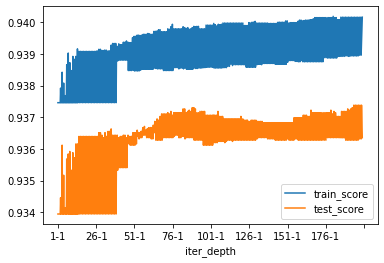

In [ ]:
scores_data.plot(x="iter_depth", y=["train_score", "test_score"], legend=True)

In [ ]:
scores_data[scores_data.total_score == scores_data.total_score.max()]

,iter_depth,train_score,test_score,total_score
0,89-4,0.939878,0.937307,1.877185


Самые высокие показатели получились при iterations = 89 и при depth = 4

In [165]:
gbm = CatBoostClassifier(iterations=89,
                          depth=4,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(Xtest)

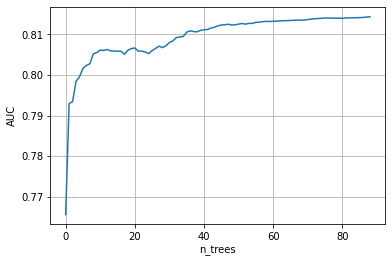

In [166]:
eval_metrics = gbm.get_evals_result()
plt.plot(eval_metrics['validation']['AUC'])
plt.xlabel('n_trees')
plt.ylabel('AUC')
plt.grid()

In [167]:
from sklearn import metrics

gbm_classes = (gbm_preds[:, 1] > 0.4)
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_preds[:, 1]))

precision:  0.5050167224080268
recall:  0.18757763975155278
auc-roc:  0.8143006944904437


Получили не плохой результат, в целом auc-roc выше чем был раньше у линейной регрессии.

Теперь попробуем подобрать параметры глядя на график.

In [147]:
gbm = CatBoostClassifier(iterations=500,
                          depth=2,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(Xtest)

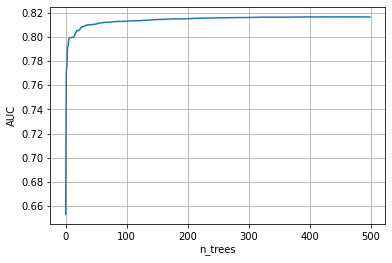

In [148]:
eval_metrics = gbm.get_evals_result()
plt.plot(eval_metrics['validation']['AUC'])
plt.xlabel('n_trees')
plt.ylabel('AUC')
plt.grid()

Кривая перестает расти примерно при iterations=320

In [159]:
gbm = CatBoostClassifier(iterations=320,
                          depth=2,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(Xtest)

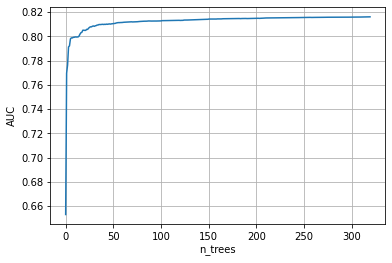

In [160]:
eval_metrics = gbm.get_evals_result()
plt.plot(eval_metrics['validation']['AUC'])
plt.xlabel('n_trees')
plt.ylabel('AUC')
plt.grid()

In [164]:
gbm_classes = (gbm_preds[:, 1] > 0.4)
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_preds[:, 1]))

precision:  0.4960254372019078
recall:  0.1937888198757764
auc-roc:  0.8161809904259169


Показатель auc-roc стал чуть выше но precision и recall получились выше в модели логистической регрессии

В нашем dataset нет категориальных признаков, поэтому заниматься их обработкой мы не будем.